# Set-up

In [1]:
import os
import sys
import glob
import time
import yaml
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import scanpy as sc
import loompy as lp
sc.settings.verbosity = 3

sys.path.append("/cellar/users/aklie/data/igvf/bin")
from utils import make_dirs

sys.path.append("/cellar/users/aklie/data/igvf/bin/data_wrangling")
from write import write_h5ad, write_loom, write_tsv

sys.path.append("/cellar/users/aklie/data/igvf/bin/data_viz")
from qc import basic_scatter_plots

sys.path.append("/cellar/users/aklie/data/igvf/bin/data_processing")
from feature_selection import select_variable_genes, select_cell_fraction_genes
from downsample import stratified_downsample

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def 

In [2]:
from typing import Literal
from normalizations import (
    total_normalize, 
    cpm_normalize, 
    rank_normalize, 
    log1p_normalize, 
    proportional_filtering_normalize,
    scale_normalize,
    sqrt_normalize,
    sct_normalize,
)


# Function for checking if data is counts
def is_counts(data, percent=1.0):
    greater_than_0 = (np.sum(data >= 0) / data.size)*100
    int_equals = (np.sum(data.astype(int) == data) / data.size)*100
    if np.all(data >= 0) and np.all(data.astype(int) == data):
        print("The matrix contains all count data.")
    elif np.sum(data >= 0) / data.size >= percent and np.sum(data.astype(int) == data) / data.size >= percent:
        print(f"The matrix contains more than {percent}% count data. Greater than 0: {greater_than_0}%, Int equals: {int_equals}%")
    else:
        print(f"The matrix contains less than {percent}% count data. Greater than 0: {greater_than_0}%, Int equals: {int_equals}%")


# Function for normalizing counts
def normalize(
    adata,
    normalization: Literal
    [
        "raw", 
        "cpm", 
        "cp10k", 
        "cpm_rank"
        "log1p", 
        "log1p_cp10k", 
        "log1p_cpm", 
        "scale_log1p_cp10k", 
        "pf",
        "log1p_pf",
        "pf_log1p_pf",
        "sqrt", 
        "sct"
    ] = "raw",
    layer_out: str = "normalized_counts",
):
    """Normalize AnnData object
    
    Parameters
    ----------
    adata : AnnData
        Annotated data matrix, cell by gene
    normalization : str, optional
        Normalization to use, by default "raw"
        Can be one of "raw", "cpm", "cp10k", "log_cp10k", "scale_log_cp10k", "cpm_rank"
    layer_out : str, optional
        Layer to save normalized counts to, by default layer_out
    
    Returns
    -------
    None
    """
    if normalization == "raw":
        print("Using raw counts")
        adata.layers[layer_out] = adata.X
    elif normalization == "cpm":
        print("Using CPM normalization")
        cpm_normalize(
            adata=adata,
            layer_out=layer_out
        )
    elif normalization == "cp10k":
        print("Using CP10K normalization")
        total_normalize(
            adata=adata,
            target_sum=1e4,
            layer_out=layer_out
        )
    elif normalization == "cpm_rank":
        print("Using CPM rank normalization")
        cpm_normalize(
            adata=adata,
            layer_out=layer_out
        )
        rank_normalize(
            adata=adata,
            layer_in=layer_out,
            layer_out=layer_out,
        )
    elif normalization == "log1p":
        print("Using log1p normalization")
        log1p_normalize(
            adata=adata,
            layer_out=layer_out,
        )
    elif normalization == "log1p_cp10k":
        print("Using log CP10K normalization")
        total_normalize(
            adata=adata,
            target_sum=1e4,
            layer_out=layer_out
        )
        log1p_normalize(
            adata=adata,
            layer_in=layer_out,
            layer_out=layer_out,
        )
    elif normalization == "log1p_cpm":
        print("Using log1p CPM normalization")
        cpm_normalize(
            adata=adata,
            layer_out=layer_out
        )
        log1p_normalize(
            adata=adata,
            layer_in=layer_out,
            layer_out=layer_out,
        )
    elif normalization == "scale_log1p_cp10k":
        print("Using scaled log CP10K normalization")
        total_normalize(
            adata=adata,
            layer_out=layer_out
        )
        log1p_normalize(
            adata=adata,
            layer_in=layer_out,
            layer_out=layer_out,
        )
        scale_normalize(
            adata=adata,
            layer_in=layer_out,
            layer_out=layer_out,
        )
    elif normalization == "pf":
        print("Using proportional filtering normalization")
        proportional_filtering_normalize(
            adata=adata,
            layer_out=layer_out,
        )
    elif normalization == "log1p_pf":
        print("Using log1p proportional filtering normalization")
        proportional_filtering_normalize(
            adata=adata,
            layer_out=layer_out,
        )
        log1p_normalize(
            adata=adata,
            layer_in=layer_out,
            layer_out=layer_out,
        )
    elif normalization == "pf_log1p_pf":
        print("Using pf log1p pf normalization")
        proportional_filtering_normalize(
            adata=adata,
            layer_out=layer_out,
        )
        log1p_normalize(
            adata=adata,
            layer_in=layer_out,
            layer_out=layer_out,
        )
        proportional_filtering_normalize(
            adata=adata,
            layer_in=layer_out,
            layer_out=layer_out,
        )
    elif normalization == "sqrt":
        print("Using sqrt normalization")
        sqrt_normalize(
            adata=adata,
            layer_out=layer_out,
        )
    elif normalization == "sct":
        print("Using SCT normalization")
        sct_normalize(
            adata=adata,
            keep_genes=True,
            layer_out=layer_out,
        )
    else:
        raise ValueError(f"normalization {normalization} not recognized")

In [5]:
# Dataset and params
dataset_name = "igvf_b01_LeftCortex"
subsets_dir = "/cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference"

# Inputs
in_dir = "/cellar/users/aklie/data/igvf/topic_grn_links/h5ad/"
in_date = "31Aug23"
in_file = "LeftCortex.h5ad"
in_data = os.path.join(in_dir, dataset_name, in_date, in_file)
print(in_data)

# Outputs
results_dir = "/cellar/users/aklie/data/igvf/topic_grn_links/"
out_date = "31Aug23"
time_id = time.strftime("%Y%m%d-%H%M%S")
run_id =  random.getrandbits(32)
run = str(run_id) + "_" + time_id
run = "3744376661_20230829-175127"
out_dir = os.path.join(subsets_dir, dataset_name,  out_date, run)
print(make_dirs(out_dir))

# Method params
cell_fracs = ["0.01", "0.05", "0.1", "0.2"]
n_var_genes = None
use_same_gene_for_all = False
normalizations = ["raw", "log1p_cp10k", "pf_log1p_pf", "cpm_rank"]
subset_columns = ["celltypes"]
column_values = ["Microglia"]
write_all_cells = False
write_tsv_flag = True

/cellar/users/aklie/data/igvf/topic_grn_links/h5ad/igvf_b01_LeftCortex/31Aug23/LeftCortex.h5ad
/cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference/igvf_b01_LeftCortex/31Aug23/3744376661_20230829-175127


In [26]:
# Make a params file
data_params = {
    "in_data": in_data,
    "out_dir": out_dir,
    "cells_removed": "All cells from sublibrary 13G were removed"
}
method_params = {
    "cell_fracs": cell_fracs,
    "n_var_genes": n_var_genes,
    "use_same_gene_for_all": use_same_gene_for_all,
    "normalizations": normalizations,
    "subset_columns": subset_columns,
    "column_values": column_values,
    "write_all_cells": write_all_cells,
    "write_tsv_flag": write_tsv_flag,
}
version_params = {
    "time_id": time_id,
    "run_id": run_id,
    "Python": sys.version[:5],
    "Scanpy": sc.__version__,
    "Loompy": lp.__version__,
}
params = {"data": data_params, "run": method_params, "versions": version_params}
params_file = os.path.join(out_dir,"subset_for_regulon_inference_params.yaml")
if not os.path.exists(os.path.join(out_dir, params_file)):
    with open(os.path.join(out_dir, params_file), "w") as f:
        yaml.dump(params, f)
else:
    print("params.yaml already exists, will not overwrite")

# Parse other args

In [27]:
# Parse args
print("Parsing command line args..")

# Input file
h5ad_file = in_data
print(f"Input file: {h5ad_file}")

# Genes to use
if cell_fracs is not None:
    print(f"Will use genes from {cell_fracs} of cells")
    feature_options = [float(cell_frac) for cell_frac in cell_fracs]
    use_variable_genes = False
elif n_var_genes is not None:
    print(f"Using variable genes: {n_var_genes}")
    feature_options = [int(n_var_gene) for n_var_gene in n_var_genes]
    use_variable_genes = True
else:
    raise ValueError("Must specify either cell_fracs or n_var_genes")

# Normalization to use
normalizations = normalizations
print(f"Normalization: {normalizations}")

# Cells to use
subset_cols = [column.strip(",") for column in subset_columns]
column_values = [value.strip(",") for value in column_values]
if len(column_values) == 0:
    column_values = None
if column_values is not None:
    print(f"Will only keep cells with {column_values} in {subset_cols}")
else:
    print(f"Will keep all cells in {subset_cols}")

# Flags
write_all_cells_flag = write_all_cells
if write_all_cells_flag:
    print("Will write files for all cells")
write_tsv_flag = write_tsv_flag
if write_tsv_flag:
    print("Will write tsv files")

# Output dir
out_dir = out_dir
print(f"Output dir: {out_dir}")

Parsing command line args..
Input file: /cellar/users/aklie/data/igvf/topic_grn_links/h5ad/igvf_b01_LeftCortex/31Aug23/LeftCortex.h5ad
Will use genes from ['0.01', '0.05', '0.1', '0.2'] of cells
Normalization: ['raw', 'log1p_cp10k', 'pf_log1p_pf', 'cpm_rank']
Will only keep cells with ['Microglia'] in ['celltypes']
Will write tsv files
Output dir: /cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference/igvf_b01_LeftCortex/31Aug23/3744376661_20230829-175127


# Load data

In [28]:
# Load in anndata
print(f"Loading {in_data}")
adata = sc.read_h5ad(in_data)

Loading /cellar/users/aklie/data/igvf/topic_grn_links/h5ad/igvf_b01_LeftCortex/31Aug23/LeftCortex.h5ad


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [29]:
is_counts(adata.X[:10, :10].todense(), percent=0.99)

The matrix contains all count data.


In [30]:
# If adata.var index looks like a simple range as strings, then take the first column of adata.var as the index
if adata.var.index[0].isdigit():
    first_col = adata.var.columns[0]
    adata.var.index = adata.var[first_col]
    adata.var.drop(columns=first_col, inplace=True)
    print(f"adata.var.index looks like a range using {first_col} as index")
if adata.obs.index[0].isdigit():
    first_col = adata.obs.columns[0]
    adata.obs.index = adata.obs[first_col]
    adata.obs.drop(columns=first_col, inplace=True)
    print(f"adata.obs.index looks like a range using {first_col} as index")

In [31]:
# Extra for this dataset (TODO: clean up h5ad)
adata.obs.index = adata.obs.index.astype(str) + "_" + adata.obs["kallisto_cellID"].astype(str)

In [32]:
# Remove batchy sublibrary for this run
adata = adata[adata.obs["sublibrary"] != "13G"]

In [33]:
# Prelim filtters, takes a bout a minute
print("Prelim filters using ScanPy min_genes=200 and min_cells=3...")
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.raw = adata

Prelim filters using ScanPy min_genes=200 and min_cells=3...


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


filtered out 24577 genes that are detected in less than 3 cells


Saving plot to /cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference/igvf_b01_LeftCortex/31Aug23/3744376661_20230829-175127/basic_scatter_plots.png...


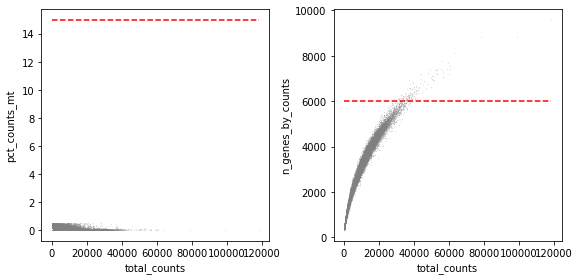

In [34]:
# Plot QC
basic_scatter_plots(adata, save=os.path.join(out_dir, "basic_scatter_plots.png"))

# Select genes for all cells if requested
I tend to lean more towards selecting genes per cell type

In [35]:
if use_same_gene_for_all:
    print("Gene selection")
    if use_variable_genes:
        adata = select_variable_genes(adata, n_genes=feature_options[0])
    else:
        adata = select_cell_fraction_genes(adata, cell_frac=feature_options[0])
    print(f"Subsetted to {adata.shape[1]} genes")
else:
    print("Genes will be selected for each subset separately")

Genes will be selected for each subset separately


# Make a random 500 cell, 2000 gene subset for testing

In [36]:
# What we are currently doing
cells = "random_500"
genes = "random_2000"

In [37]:
# Subset -- 500 cells, 2000 genes
print("Subsetting genes for Subset to 500 cells, 2000 genes")
rand_cells = adata.obs.index.isin(np.random.choice(adata.obs_names, 500, replace=False))
rand_genes = adata.var.index.isin(np.random.choice(adata.var_names, 2000, replace=False))
curr_ad = adata[rand_cells, rand_genes]
curr_ad

Subsetting genes for Subset to 500 cells, 2000 genes


View of AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'kallisto_cellID', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'bc1_well', 'bc2_well', 'bc3_well', 'sublibrary', 'Experiment', 'Kit', 'Tissue', 'Mouse_Tissue_ID', 'Genotype', 'Sex', 'Replicate', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Tissue_weight_mg', 'nCount_RNA', 'nFeature_RNA', 'doublet_scores', 'percent.mt', 'percent.ribo', 'G2M.Score', 'seurat_clusters', 'celltypes', 'subtypes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [38]:
# For each normalization, normalize and write to disk
for normalization in normalizations:
    print(f"Normalizing with {normalization}")
    normalize(
        adata=curr_ad,
        normalization=normalization,
    )
    make_dirs(os.path.join(out_dir, cells, genes, normalization))
    print(f"Writing to disk in {os.path.join(out_dir, cells, genes, normalization)}")
    write_h5ad(adata=curr_ad, filename=os.path.join(out_dir, cells, genes, normalization, f"{cells}.{genes}.{normalization}.h5ad"))
    write_loom(adata=curr_ad, filename=os.path.join(out_dir, cells, genes, normalization, f"{cells}.{genes}.{normalization}.loom"), layer="normalized_counts")
    if write_tsv_flag:
        write_tsv(adata=curr_ad, filename=os.path.join(out_dir, cells, genes, normalization, f"{cells}.{genes}.{normalization}.tsv"), layer="normalized_counts")
    print()

Normalizing with raw
Using raw counts
Writing to disk in /cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference/igvf_b01_LeftCortex/31Aug23/3744376661_20230829-175127/random_500/random_2000/raw
Saving as h5ad to /cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference/igvf_b01_LeftCortex/31Aug23/3744376661_20230829-175127/random_500/random_2000/raw/random_500.random_2000.raw.h5ad
Saving as loom to /cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference/igvf_b01_LeftCortex/31Aug23/3744376661_20230829-175127/random_500/random_2000/raw/random_500.random_2000.raw.loom
Saving tsv to /cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference/igvf_b01_LeftCortex/31Aug23/3744376661_20230829-175127/random_500/random_2000/raw/random_500.random_2000.raw.tsv

Normalizing with log1p_cp10k
Using log CP10K normalization
normalizing counts per cell
    finished (0:00:00)
Writing to disk in /cellar/users/aklie/data/igvf/topic_

# Do the columns subsets specified

In [39]:
# Column subsets
print(f"Found {subset_cols} columns to subset on")
for column in subset_cols:
    
    # If column is not in adata.obs.columns, skip
    if column not in adata.obs.columns:
        print(f"Column {column} not found in {adata.obs.columns}, skipping...")
        continue
    
    # If column is in adata.obs.columns, subset 
    cells_options = adata.obs[column].unique()
    print(f"Found {list(cells_options.categories)} values for {column}")
    for cells in cells_options:
        
        # If we don't find the current value in the column_values, skip
        if column_values is not None and cells not in column_values:
            print(f"\t{column}={cells} not found in {column_values}, skipping...")
            continue
        
        # Subset to those cells
        print(f"\nFound {column}={cells}, subsetting")
        curr_ad = adata[adata.obs[column] == cells].copy()
        print(f"Subsetted to {curr_ad.shape[0]} cells")
        
        # Loop through and write each subset to disk
        for genes in feature_options:

            # Subset to genes of interest for microglia
            if not use_same_gene_for_all:
                if use_variable_genes:
                    curr_ad = select_variable_genes(curr_ad, n_genes=genes)
                else:
                    curr_ad = select_cell_fraction_genes(curr_ad, cell_frac=genes)
                print(f"Subsetted to {curr_ad.shape[1]} genes")
            else:
                print("Genes already selected for all cells")
        
            # For each normalization, normalize and write to disk
            for normalization in normalizations:
                print()

                # Normalize based on microglia
                normalize(adata=curr_ad, normalization=normalization)

                # Write to disk in output dir for current configuration
                cells = cells.lower()
                curr_out_dir = os.path.join(out_dir, cells, str(genes), normalization)
                if os.path.exists(curr_out_dir):
                    print(f"Output dir {curr_out_dir} already exists, skipping")
                    continue
                else:
                    print(f"Writing to disk in {curr_out_dir}")
                    make_dirs(curr_out_dir)
                write_h5ad(adata=curr_ad, filename=os.path.join(curr_out_dir, f"{cells}-both.{genes}.{normalization}.h5ad"))
                write_loom(adata=curr_ad, filename=os.path.join(curr_out_dir, f"{cells}-both.{genes}.{normalization}.loom"), layer="normalized_counts")
                if write_tsv_flag:
                    write_tsv(adata=curr_ad, filename=os.path.join(curr_out_dir, f"{cells}-both.{genes}.{normalization}.tsv"), layer="normalized_counts")

                # Now we will split based on genotype but use the same genes in the subset for each
                genotypes = curr_ad.obs["Genotype"].unique()
                for genotype in genotypes:
                    print()
                    curr_ad_geno = curr_ad[curr_ad.obs["Genotype"] == genotype].copy()
                    print(f"Using {curr_ad_geno.shape[0]} cells and {curr_ad_geno.shape[1]} genes for {genotype}")
                    write_h5ad(adata=curr_ad_geno, filename=os.path.join(curr_out_dir, f"{cells}-{genotype}.{genes}.{normalization}.h5ad"))
                    write_loom(adata=curr_ad_geno, filename=os.path.join(curr_out_dir, f"{cells}-{genotype}.{genes}.{normalization}.loom"), layer="normalized_counts")
                    if write_tsv_flag:
                        write_tsv(adata=curr_ad_geno, filename=os.path.join(curr_out_dir, f"{cells}-{genotype}.{genes}.{normalization}.tsv"), layer="normalized_counts")
            print()            

Found ['celltypes'] columns to subset on
Found ['Astrocyte', 'Endothelial', 'Ependymal', 'GABA', 'GLUT', 'Microglia', 'OPC', 'Oligodendrocyte', 'Pericyte', 'VLMC'] values for celltypes
	celltypes=GABA not found in ['Microglia'], skipping...
	celltypes=GLUT not found in ['Microglia'], skipping...
	celltypes=OPC not found in ['Microglia'], skipping...

Found celltypes=Microglia, subsetting
Subsetted to 2843 cells
Subsetting genes with cell_frac=0.01...
filtered out 22963 genes that are detected in less than 28.43 cells
Subsetted to 9413 genes

Using raw counts
Writing to disk in /cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference/igvf_b01_LeftCortex/31Aug23/3744376661_20230829-175127/microglia/0.01/raw
Saving as h5ad to /cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference/igvf_b01_LeftCortex/31Aug23/3744376661_20230829-175127/microglia/0.01/raw/microglia-both.0.01.raw.h5ad
Saving as loom to /cellar/users/aklie/data/igvf/topic_grn_links/subse

# Different manual subsets

In [51]:
# Hold the subsets
subset_dict = {}

## Balanced subsample of celltypes

In [52]:
# Check how many cells we have for each celltype
print(adata.obs["celltypes"].value_counts())

GLUT               33174
GABA               18408
Astrocyte           9316
Oligodendrocyte     7794
Microglia           2843
OPC                 2622
VLMC                1329
Endothelial          760
Pericyte             540
Ependymal            114
Name: celltypes, dtype: int64


In [53]:
# Do a stratified downsample to 630 cells per celltype (lowest number of cells for a celltype)
subset_ad = stratified_downsample(adata, group_by="celltypes", target_cells_per_group=760)

# Check the result
print(subset_ad.obs["celltypes"].value_counts())

subset_ad

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


Astrocyte          760
Endothelial        760
GABA               760
GLUT               760
Microglia          760
OPC                760
Oligodendrocyte    760
VLMC               760
Pericyte           540
Ependymal          114
Name: celltypes, dtype: int64


AnnData object with n_obs × n_vars = 6734 × 32376
    obs: 'kallisto_cellID', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'bc1_well', 'bc2_well', 'bc3_well', 'sublibrary', 'Experiment', 'Kit', 'Tissue', 'Mouse_Tissue_ID', 'Genotype', 'Sex', 'Replicate', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Tissue_weight_mg', 'nCount_RNA', 'nFeature_RNA', 'doublet_scores', 'percent.mt', 'percent.ribo', 'G2M.Score', 'seurat_clusters', 'celltypes', 'subtypes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [54]:
# Add to sample dict
subset_dict["balanced_subsample_celltypes"] = subset_ad

## Subsample celltypes uniformly

In [55]:
# What fraction is 4410 cells
subsample_frac = 6734 / adata.shape[0]
subset_ad = sc.pp.subsample(adata, fraction=subsample_frac, copy=True)
subset_ad

AnnData object with n_obs × n_vars = 6734 × 32376
    obs: 'kallisto_cellID', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'bc1_well', 'bc2_well', 'bc3_well', 'sublibrary', 'Experiment', 'Kit', 'Tissue', 'Mouse_Tissue_ID', 'Genotype', 'Sex', 'Replicate', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Tissue_weight_mg', 'nCount_RNA', 'nFeature_RNA', 'doublet_scores', 'percent.mt', 'percent.ribo', 'G2M.Score', 'seurat_clusters', 'celltypes', 'subtypes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [56]:
subset_dict["uniform_subsample_celltypes"] = subset_ad

## Microglia but balanced for genotype

In [57]:
# Microglia only but randomly keep CASTJ as the same number of cells as B6J
print("Randomly keeping CASTJ as the same number of cells as B6J")
subset_ad = adata[adata.obs["celltypes"] == "Microglia"].copy()
print(subset_ad.obs["celltypes"].value_counts())
print(subset_ad.obs["Genotype"].value_counts())
b6j_cells = subset_ad.obs.index[subset_ad.obs["Genotype"] == "B6J"]
castj_cells = subset_ad.obs.index[subset_ad.obs["Genotype"] == "CASTJ"]
min_cells = min(len(b6j_cells), len(castj_cells))
b6j_cells = np.random.choice(b6j_cells, min_cells, replace=False)
castj_cells = np.random.choice(castj_cells, min_cells, replace=False)
subset_ad = subset_ad[subset_ad.obs.index.isin(b6j_cells) | subset_ad.obs.index.isin(castj_cells)].copy()
print(subset_ad.obs["celltypes"].value_counts())
print(subset_ad.obs["Genotype"].value_counts())
subset_ad

Randomly keeping CASTJ as the same number of cells as B6J


Microglia    2843
Name: celltypes, dtype: int64
B6J      1637
CASTJ    1206
Name: Genotype, dtype: int64
Microglia    2412
Name: celltypes, dtype: int64
B6J      1206
CASTJ    1206
Name: Genotype, dtype: int64


AnnData object with n_obs × n_vars = 2412 × 32376
    obs: 'kallisto_cellID', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'bc1_well', 'bc2_well', 'bc3_well', 'sublibrary', 'Experiment', 'Kit', 'Tissue', 'Mouse_Tissue_ID', 'Genotype', 'Sex', 'Replicate', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Tissue_weight_mg', 'nCount_RNA', 'nFeature_RNA', 'doublet_scores', 'percent.mt', 'percent.ribo', 'G2M.Score', 'seurat_clusters', 'celltypes', 'subtypes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [58]:
subset_dict["balanced_genotype_microglia"] = subset_ad

## Microglia and oligodendrocytes together balanced on cell type

In [59]:
# Subset to those cells that are Microglia and Oligodendrocyte celltypes
microglia = adata.obs.index[adata.obs["celltypes"] == "Microglia"]
oligodendrocyte = adata.obs.index[adata.obs["celltypes"] == "Oligodendrocyte"]
min_cells = min(len(microglia), len(oligodendrocyte))
oligodendrocyte = np.random.choice(oligodendrocyte, min_cells, replace=False)
subset_ad = adata[adata.obs.index.isin(microglia) | adata.obs.index.isin(oligodendrocyte)]
print(subset_ad.obs["celltypes"].value_counts())
subset_ad

Microglia          2843
Oligodendrocyte    2843
Name: celltypes, dtype: int64


View of AnnData object with n_obs × n_vars = 5686 × 32376
    obs: 'kallisto_cellID', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'bc1_well', 'bc2_well', 'bc3_well', 'sublibrary', 'Experiment', 'Kit', 'Tissue', 'Mouse_Tissue_ID', 'Genotype', 'Sex', 'Replicate', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Tissue_weight_mg', 'nCount_RNA', 'nFeature_RNA', 'doublet_scores', 'percent.mt', 'percent.ribo', 'G2M.Score', 'seurat_clusters', 'celltypes', 'subtypes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [60]:
subset_dict["balanced_celltype_microglia_oligodendrocyte"] = subset_ad

## Microglia and oligodendrocytes together balanced on cell type and genotype

In [61]:
# Microglia and oligodendrocyte only but randomly keep the same number of cells for each celltype and each genotype
print("Randomly keeping the same number of cells for each celltype and each genotype")
b6j_microglia = adata.obs.index[(adata.obs["Genotype"] == "B6J") & (adata.obs["celltypes"] == "Microglia")]
castj_microglia = adata.obs.index[(adata.obs["Genotype"] == "CASTJ") & (adata.obs["celltypes"] == "Microglia")]
b6j_oligodendrocyte = adata.obs.index[(adata.obs["Genotype"] == "B6J") & (adata.obs["celltypes"] == "Oligodendrocyte")]
castj_oligodendrocyte = adata.obs.index[(adata.obs["Genotype"] == "CASTJ") & (adata.obs["celltypes"] == "Oligodendrocyte")]
min_cells = min(len(b6j_microglia), len(castj_microglia), len(b6j_oligodendrocyte), len(castj_oligodendrocyte))
b6j_microglia = np.random.choice(b6j_microglia, min_cells, replace=False)
castj_microglia = np.random.choice(castj_microglia, min_cells, replace=False)
b6j_oligodendrocyte = np.random.choice(b6j_oligodendrocyte, min_cells, replace=False)
castj_oligodendrocyte = np.random.choice(castj_oligodendrocyte, min_cells, replace=False)
subset_ad = adata[adata.obs.index.isin(b6j_microglia) | adata.obs.index.isin(castj_microglia) | adata.obs.index.isin(b6j_oligodendrocyte) | adata.obs.index.isin(castj_oligodendrocyte)].copy()
print(subset_ad.obs["celltypes"].value_counts())
print(subset_ad.obs["Genotype"].value_counts())
print(pd.crosstab(subset_ad.obs["celltypes"], subset_ad.obs["Genotype"]))
subset_ad

Randomly keeping the same number of cells for each celltype and each genotype
Microglia          2412
Oligodendrocyte    2412
Name: celltypes, dtype: int64
B6J      2412
CASTJ    2412
Name: Genotype, dtype: int64
Genotype          B6J  CASTJ
celltypes                   
Microglia        1206   1206
Oligodendrocyte  1206   1206


AnnData object with n_obs × n_vars = 4824 × 32376
    obs: 'kallisto_cellID', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'bc1_well', 'bc2_well', 'bc3_well', 'sublibrary', 'Experiment', 'Kit', 'Tissue', 'Mouse_Tissue_ID', 'Genotype', 'Sex', 'Replicate', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Tissue_weight_mg', 'nCount_RNA', 'nFeature_RNA', 'doublet_scores', 'percent.mt', 'percent.ribo', 'G2M.Score', 'seurat_clusters', 'celltypes', 'subtypes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [62]:
subset_dict["balanced_genotype-celltype_microglia_oligodendrocyte"] = subset_ad

## Create the subsets

In [63]:
subset_dict

{'balanced_subsample_celltypes': AnnData object with n_obs × n_vars = 6734 × 32376
     obs: 'kallisto_cellID', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'bc1_well', 'bc2_well', 'bc3_well', 'sublibrary', 'Experiment', 'Kit', 'Tissue', 'Mouse_Tissue_ID', 'Genotype', 'Sex', 'Replicate', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Tissue_weight_mg', 'nCount_RNA', 'nFeature_RNA', 'doublet_scores', 'percent.mt', 'percent.ribo', 'G2M.Score', 'seurat_clusters', 'celltypes', 'subtypes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch'
     var: 'gene_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts',
 'uniform_subsample_celltypes': AnnData object with n_obs × n_vars = 6734 × 32376
     obs: 'kallisto_cellID', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'bc1_well', 'bc2_well', 'bc3_well', 'sublibrary', 'Experiment', 'Kit', 'Tissue', 'Mouse_Tissue_ID', 'Genotype', 'Sex', 'Replicate', 'Age_days'

In [64]:
for cells, subset_ad in subset_dict.items():

    # Double check
    print(subset_ad.obs.celltypes.value_counts())
    print(subset_ad.obs.Genotype.value_counts())
    xtab = pd.crosstab(subset_ad.obs.Genotype, subset_ad.obs.celltypes)
    make_dirs(os.path.join(out_dir, cells))
    xtab.to_csv(os.path.join(out_dir, cells, "celltype_by_genotype_counts.csv"))

    # Loop through and write each subset to disk
    for genes in feature_options:

        # Subset to genes of interest for microglia
        if not use_same_gene_for_all:
            if use_variable_genes:
                curr_ad = select_variable_genes(subset_ad, n_genes=genes)
            else:
                curr_ad = select_cell_fraction_genes(subset_ad, cell_frac=genes)
            print(f"Subsetted to {curr_ad.shape[1]} genes")
        else:
            print("Genes already selected for all cells")
        
        # For each normalization, normalize and write to disk
        for normalization in normalizations:
            print()

            # Normalize based on microglia
            normalize(adata=curr_ad, normalization=normalization)

            # Write to disk in output dir for current configuration
            curr_out_dir = os.path.join(out_dir, cells, str(genes), normalization)
            if os.path.exists(curr_out_dir):
                print(f"Output dir {curr_out_dir} already exists, skipping")
                continue
            else:
                print(f"Writing to disk in {curr_out_dir}")
                make_dirs(curr_out_dir)
            write_h5ad(adata=curr_ad, filename=os.path.join(curr_out_dir, f"{cells}-both.{genes}.{normalization}.h5ad"))
            write_loom(adata=curr_ad, filename=os.path.join(curr_out_dir, f"{cells}-both.{genes}.{normalization}.loom"), layer="normalized_counts")
            if write_tsv_flag:
                write_tsv(adata=curr_ad, filename=os.path.join(curr_out_dir, f"{cells}-both.{genes}.{normalization}.tsv"), layer="normalized_counts")
            
            # Now we will split based on genotype but use the same genes in the subset for each
            genotypes = curr_ad.obs["Genotype"].unique()
            for genotype in genotypes:
                print()
                curr_ad_geno = curr_ad[curr_ad.obs["Genotype"] == genotype]
                print(f"Using {curr_ad_geno.shape[0]} cells and {curr_ad_geno.shape[1]} genes for {genotype}")
                write_h5ad(adata=curr_ad_geno, filename=os.path.join(curr_out_dir, f"{cells}-{genotype}.{genes}.{normalization}.h5ad"))
                write_loom(adata=curr_ad_geno, filename=os.path.join(curr_out_dir, f"{cells}-{genotype}.{genes}.{normalization}.loom"), layer="normalized_counts")
                if write_tsv_flag:
                    write_tsv(adata=curr_ad_geno, filename=os.path.join(curr_out_dir, f"{cells}-{genotype}.{genes}.{normalization}.tsv"), layer="normalized_counts")
        print()

Astrocyte          760
Endothelial        760
GABA               760
GLUT               760
Microglia          760
OPC                760
Oligodendrocyte    760
VLMC               760
Pericyte           540
Ependymal          114
Name: celltypes, dtype: int64
B6J      3797
CASTJ    2937
Name: Genotype, dtype: int64
Subsetting genes with cell_frac=0.01...
filtered out 19556 genes that are detected in less than 67.34 cells
Subsetted to 12820 genes

Using raw counts
Writing to disk in /cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference/igvf_b01_LeftCortex/31Aug23/3744376661_20230829-175127/balanced_subsample_celltypes/0.01/raw
Saving as h5ad to /cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference/igvf_b01_LeftCortex/31Aug23/3744376661_20230829-175127/balanced_subsample_celltypes/0.01/raw/balanced_subsample_celltypes-both.0.01.raw.h5ad
Saving as loom to /cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference/igvf_b01_LeftCo

# Sanity check results

In [65]:
verbose = False
feature_options = ["random_2000", 0.01, 0.05, 0.1, 0.2]
samples_options = ["random_500",
                   "uniform_subsample_celltypes",
                   "balanced_subsample_celltypes", 
                   "microglia",
                   "balanced_genotype_microglia", 
                   "balanced_celltype_microglia_oligodendrocyte",
                   "balanced_genotype-celltype_microglia_oligodendrocyte"
                    ]
file_lst, file_type_list, cells_lst, genes_lst, normalization_lst = [], [], [], [], []
n_cells_lst, n_genes_lst = [], []
percent_int_list, percent_0_lst, percent_less_than_0 = [], [], []
for cells in samples_options:
    for genes in feature_options:
        for normalization in normalizations:
            
            curr_dir = os.path.join(out_dir, cells, str(genes), normalization)
            print(f"Looking in {curr_dir}")
            h5ad_files = sorted(glob.glob(os.path.join(curr_dir, "*.h5ad")))
            loom_files = sorted(glob.glob(os.path.join(curr_dir, "*.loom")))
            tsv_files = sorted(glob.glob(os.path.join(curr_dir, "*.tsv")))
            all_files = h5ad_files + loom_files + tsv_files
            print(f"\tFound {len(all_files)} total files")
            
            for i in range(len(all_files)):
                curr_file = all_files[i]
                curr_file_ext = os.path.splitext(curr_file)[1]
                if verbose:
                    print(f"\tProcessing {curr_file}")
                if curr_file_ext == ".h5ad":
                    ad = sc.read_h5ad(curr_file)
                    mat = ad.layers["normalized_counts"]
                    
                elif curr_file_ext == ".loom":
                    ad = sc.read_loom(curr_file)
                    mat = ad.X
                elif curr_file_ext == ".tsv":
                    ad = pd.read_csv(curr_file, sep="\t")
                    mat = ad.values[:, 1:]
                else:
                    print(f"\tSkipping {curr_file}")
                    continue
                if sparse.issparse(mat):
                        mat = mat.todense()
                # Get some stats on the mat
                file_lst.append(os.path.basename(curr_file))
                file_type_list.append(curr_file_ext)
                cells_lst.append(cells)
                genes_lst.append(genes)
                normalization_lst.append(normalization)
                n_genes_lst.append(mat.shape[1])
                n_cells_lst.append(mat.shape[0])
                percent_int_list.append(np.sum(mat.astype(int) == mat) / mat.size)
                percent_0_lst.append(np.sum(mat == 0.0) / mat.size)
                percent_less_than_0.append(np.sum(mat < 0.0) / mat.size)
            
            # Update the metadata ans save
            metadata_df = pd.DataFrame({
                "file": file_lst,
                "file_type": file_type_list,
                "cells": cells_lst,
                "genes": genes_lst,
                "normalization": normalization_lst,
                "n_cells": n_cells_lst,
                "n_genes": n_genes_lst,
                "percent_int": percent_int_list,
                "percent_0": percent_0_lst,
                "percent_less_than_0": percent_less_than_0,
            })
            metadata_df.to_csv(os.path.join(out_dir, "file_metadata.tsv"), index=False, sep="\t")
            print()

Looking in /cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference/igvf_b01_LeftCortex/31Aug23/3744376661_20230829-175127/random_500/random_2000/raw
	Found 3 total files

Looking in /cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference/igvf_b01_LeftCortex/31Aug23/3744376661_20230829-175127/random_500/random_2000/log1p_cp10k
	Found 3 total files

Looking in /cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference/igvf_b01_LeftCortex/31Aug23/3744376661_20230829-175127/random_500/random_2000/pf_log1p_pf
	Found 3 total files

Looking in /cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference/igvf_b01_LeftCortex/31Aug23/3744376661_20230829-175127/random_500/random_2000/cpm_rank
	Found 3 total files

Looking in /cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference/igvf_b01_LeftCortex/31Aug23/3744376661_20230829-175127/random_500/0.01/raw
	Found 0 total files

Looking in /cellar/users/aklie/

In [ ]:
# Read in all cells
ad = pd.read_csv("/cellar/users/aklie/data/igvf/topic_grn_links/subsets/for_regulon_inference/Bridge_Satpathy/29Aug23/3744376661_20230829-175127/microglia/0.2/pf_log1p_pf/microglia-B6J.0.2.pf_log1p_pf.tsv", sep="\t")
ad.values[]

# DONE !

---

# Scratch